# Tour of the TESS Planet Search Products
<a id="title_ID"></a>
TESS does a search of the postage-stamp, 2-min cadence data. For every signal it identifies with its Transit Planet Search (TPS) module, it creates something called a Threshold crossing event (TCE).  TCEs are periodic signals with a period and epoch. Some are consistent with transiting planets, others are eclipsing binaries, and others are more consistent with variable stars or noise in the data. 

The Data Validation module of the pipeline produces a set of products that can help validate the quality of a TCE. The DV products include a time series file of the flattened light curve that was searched, a DV report and summary that shows a few plots and relevant statistics, and an xml file that contains the results of the planet transit fit.

This notebook will show you the contents of the data validation time series files and show how it can be used to obtain a quick look at the TCE.

At the end we also introduce the exo.mast API that allows a user to retrieve a bokeh plot of any tce.



## Import Statements for this notebook

In [56]:
from astropy.io import fits
import matplotlib.pyplot as plt

%matplotlib inline

## Get DV Time Series File
Get the DV Time Series File for TIC 2018235142541, which happens to be the same star as WASP-18.

In [12]:
#NEEDS UPDATING BASED ON WEB LOCATION OR ASTROQUERY
dvtfilename="/Users/smullally/TESS/TCEs/Sector2/dvt/tess2018235142541-s0002-s0002-0000000100100827-00109_dvt.fits"

## Content of the DV Time Series File
The DV Time series file is FITS file with a primary extension and one extension per TCE found in the lightcurve of the specified TIC ID.  The final extension provides some statistics about the search.

A Simple info call after reading in the file will reveal this structure.  Since there are to TCE extensions, that means two possible exoplanets were found by the SPOC pipeline on this star.

In [51]:
dvt=fits.open(dvtfilename)
dvt.info()

Filename: /Users/smullally/TESS/TCEs/Sector2/dvt/tess2018235142541-s0002-s0002-0000000100100827-00109_dvt.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      43   ()      
  1  TCE_1         1 BinTableHDU     92   19737R x 10C   [D, E, J, E, E, E, E, E, E, E]   
  2  TCE_2         1 BinTableHDU     92   19737R x 10C   [D, E, J, E, E, E, E, E, E, E]   
  3  Statistics    1 BinTableHDU    157   19737R x 38C   [D, E, J, E, E, E, E, J, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E]   


### Primary Header
The Primary header contains information about the star from the TIC. We will store the effective temperature and gravity into a variable for later use.

In [55]:
star_teff=dvt[0].header['TEFF']
star_logg=dvt[0].header['LOGG']
star_tmap=dvt[0].header['TMAG']
dvt[0].header

SIMPLE  =                    T / conforms to FITS standards                     
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
EXTEND  =                    T / file contains extensions                       
NEXTEND =                    4 / number of standard extensions                  
EXTNAME = 'PRIMARY '           / name of extension                              
EXTVER  =                    1 / extension version number (not format version)  
SIMDATA =                    F / file is based on simulated data                
ORIGIN  = 'NASA/Ames'          / institution responsible for creating this file 
DATE    = '2018-10-06'         / file creation date.                            
TSTART  =    1354.105280000743 / observation start time in TJD                  
TSTOP   =    1381.518180460247 / observation stop time in TJD                   
DATE-OBS= '2018-08-23T14:30:

### TCE EXTENSION
TCE extension contains information about the signal that was found in the light curve. It provides the light curve that was used to find the signal (unwhitened, LC_INIT and whitened, LC_WHITE).  The resulting model is given as MODEL_INIT.  The parameters of that transit model can be found in the header of the file, including the period, epoch, duration and depth of the transit.  Here we list the column names and put some of the important information in useful variables for later use.

In [59]:
dvt[1].columns

ColDefs(
    name = 'TIME'; format = 'D'; unit = 'BJD - 2457000, days'; disp = 'D14.7'
    name = 'TIMECORR'; format = 'E'; unit = 'd'; disp = 'E14.7'
    name = 'CADENCENO'; format = 'J'; disp = 'I10'
    name = 'PHASE'; format = 'E'; unit = 'days'; disp = 'E14.7'
    name = 'LC_INIT'; format = 'E'; unit = 'dimensionless'; disp = 'E14.7'
    name = 'LC_INIT_ERR'; format = 'E'; unit = 'dimensionless'; disp = 'E14.7'
    name = 'LC_WHITE'; format = 'E'; unit = 'dimensionless'; disp = 'E14.7'
    name = 'LC_DETREND'; format = 'E'; unit = 'dimensionless'; disp = 'E14.7'
    name = 'MODEL_INIT'; format = 'E'; unit = 'dimensionless'; disp = 'E14.7'
    name = 'MODEL_WHITE'; format = 'E'; unit = 'dimensionless'; disp = 'E14.7'
)

In [61]:
phase=dvt[1].data['PHASE']
flux=hdu[1].data['LC_INIT']
model=hdu[1].data['MODEL_INIT']
time=hdu[1].data['TIME']

period=dvt[1].header['TPERIOD']
dur=dvt[1].header['TDUR']
epoch=dvt[1].header['TEPOCH']
depth=dvt[1].header['TDEPTH']
dur_days=dur/24

### Plot the folded light cure and model
Notice that the phase column already has taken the times and phased them according to the period and epoch in the header.

Text(0.5,1,'Folded lightcurve and transit model.')

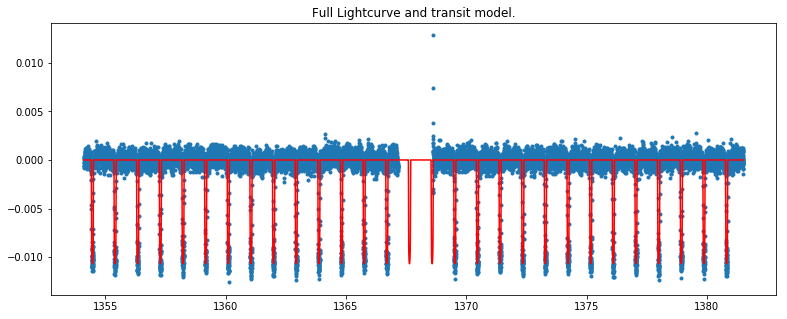

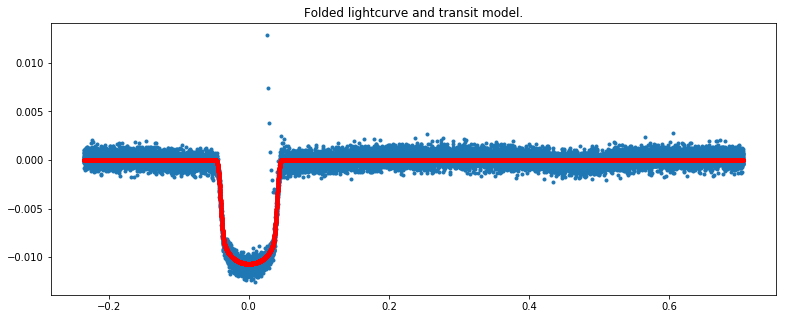

In [69]:
plt.figure(figsize=(13,5))
plt.plot(time,flux,'.')
plt.plot(time,model,'r-')
plt.title('Full Lightcurve and transit model.')

plt.figure(figsize=(13,5))
plt.plot(phase,flux,'.')
plt.plot(phase,model,'r.')
plt.title('Folded lightcurve and transit model.')

### Statistics Extension
The Statistics extension holds the SES correlation time series and the SES normalization time series for each of the pipeline's search durations. For more information see the papers linked at the end of this tutorial. These are used to calculate the CDPP time series.

In [71]:
dvt[3].columns

ColDefs(
    name = 'TIME'; format = 'D'; unit = 'BJD - 2457000, days'; disp = 'D14.7'
    name = 'TIMECORR'; format = 'E'; unit = 'd'; disp = 'E14.7'
    name = 'CADENCENO'; format = 'J'; disp = 'I10'
    name = 'PDCSAP_FLUX'; format = 'E'; unit = 'e-/s'; disp = 'E14.7'
    name = 'PDCSAP_FLUX_ERR'; format = 'E'; unit = 'sigma'; disp = 'E14.7'
    name = 'RESIDUAL_LC'; format = 'E'; unit = 'dimensionless'; disp = 'E14.7'
    name = 'DEWEIGHTS'; format = 'E'; unit = 'proportion'; disp = 'E14.7'
    name = 'QUALITY'; format = 'J'; disp = 'B16.16'
    name = 'SES_CORR_0_5'; format = 'E'; disp = 'E14.7'
    name = 'SES_CORR_1_0'; format = 'E'; disp = 'E14.7'
    name = 'SES_CORR_1_5'; format = 'E'; disp = 'E14.7'
    name = 'SES_CORR_2_0'; format = 'E'; disp = 'E14.7'
    name = 'SES_CORR_2_5'; format = 'E'; disp = 'E14.7'
    name = 'SES_CORR_3_0'; format = 'E'; disp = 'E14.7'
    name = 'SES_CORR_3_5'; format = 'E'; disp = 'E14.7'
    name = 'SES_CORR_4_5'; format = 'E'; disp = 'E14.7'


<a id="about_ID"></a>
## About this Notebook
**Author:** Susan E. Mullally, STScI Archive Scientist
<br>**Updated On:** 2018-11-15

[Top of Page](#title_ID)
<img style="float: right;" src="./stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="stsci_pri_combo_mark_horizonal_white_bkgd" width="200px"/> 